In [367]:
from datetime import timedelta
from datetime import datetime
import scipy.stats as stats
import numpy as np
import seaborn as sns
from time import time
import pandas as pd
import matplotlib.dates as mdates
import statsmodels.api as sm
import statsmodels.stats.outliers_influence as variance_inflation_factor
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()
file_name = "final_data.csv"
df_raw = pd.read_csv(file_name)
start_year = 1994
end_year = 2022
df_raw.columns


Index(['Unnamed: 0', 'year_month', 'mean_monthly_sunshine',
       'mean_monthly_shade_temperature', 'mean_monthly_humidity',
       'month_index', 'January', 'February', 'March', 'April', 'May', 'June',
       'July', 'August', 'September', 'October', 'November', 'December',
       'mean_monthly_rainfall', 'mean_monthly_morning_humidity',
       'mean_monthly_afternoon_humidity', 'mean_monthly_min_shade_temperature',
       'mean_monthly_max_shade_temperature'],
      dtype='object')

In [368]:
# df_raw[["year_month", "mean_monthly_rainfall"]]
# df["index"] = np.arange(1, len(df["year_month"])+1)
temp_dates = []


def date_parser(s):
    return datetime.strptime(year+"-"+str(month+1)+"-"+"1", '%Y-%m-%d')


for cell in df_raw["year_month"]:
    # print(cell)
    [year, month] = cell.split("_")
    month = int(month)
    # d = datetime.strptime(year+"-"+str(month+1)+"-"+"1", '%Y-%m-%d')
    d = datetime(int(year), int(month)+1, 1)
    temp_dates.append(d)


temp_2017 = pd.DataFrame()
# temp_2017 = temp_2017[273:285]
temp_2017 = df_raw[["mean_monthly_rainfall", "mean_monthly_humidity", "mean_monthly_sunshine",
                    "mean_monthly_min_shade_temperature",
                    "mean_monthly_max_shade_temperature",
                    "May",
                    "June",
                    "July",
                    "August",
                    "September",
                    "November",
                    "December"]]
temp_2017["date"] = pd.DataFrame(temp_dates)
df_multi_2017 = temp_2017[273:285]
df_multi_2017.set_index("date", inplace=True)
df = pd.DataFrame()
# df_raw["mean_monthly_rainfall"]
df["date"] = pd.DataFrame(temp_dates)
df["mean_monthly_rainfall"] = df_raw["mean_monthly_rainfall"]
df.set_index("date", inplace=True)
# df.asfreq(pd.infer_freq(df.index))
df = df.asfreq(freq="MS")
# df_multi_2017.head()
# print(df.index.values)


C:\Users\simeo\AppData\Local\Temp\ipykernel_13948\97088988.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_2017["date"] = pd.DataFrame(temp_dates)


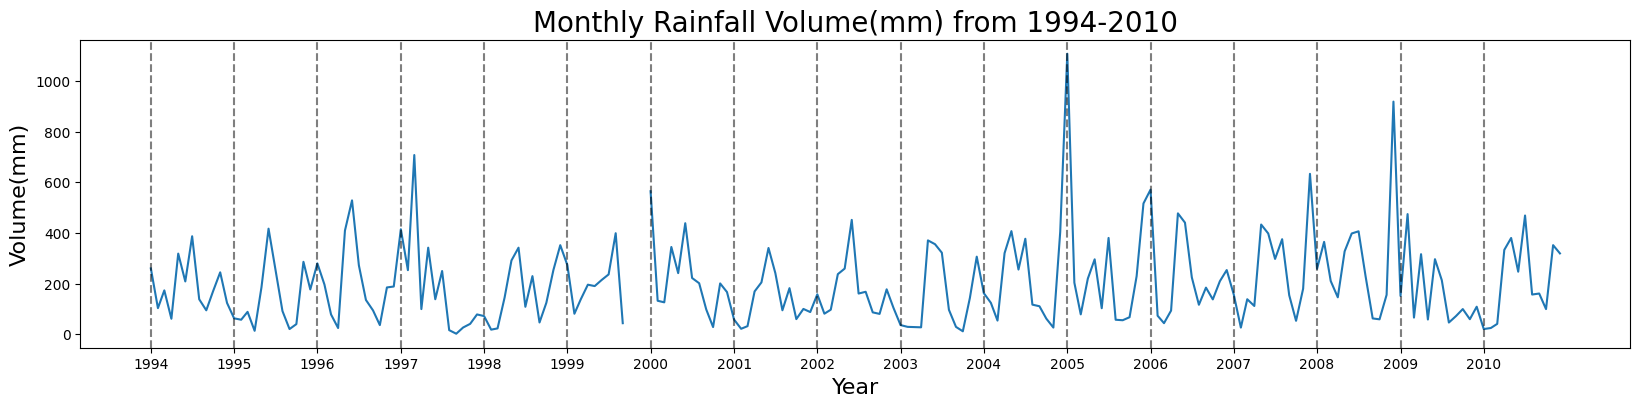

In [369]:
plt.figure(figsize=(20, 4))
start_date = pd.to_datetime("1994-01-01")
end_date = pd.to_datetime("2010-12-01")
df_1994_2010 = df[start_date:end_date]
df_1994_2010.tail()
plt.title("Monthly Rainfall Volume(mm) from 1994-2010", fontsize=20)
plt.ylabel("Volume(mm)", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.plot(df_1994_2010["mean_monthly_rainfall"])
tick_loc = [pd.to_datetime(str(i), format="%Y") for i in range(1994, 2010+1)]
tick_labels = ["{}".format(i.year) for i in tick_loc]
plt.xticks(ticks=tick_loc, labels=tick_labels)
for year in range(1994, 2010+1):
    plt.axvline(pd.to_datetime(str(year)+"-01-01"),
                color="k", linestyle='--', alpha=0.5)


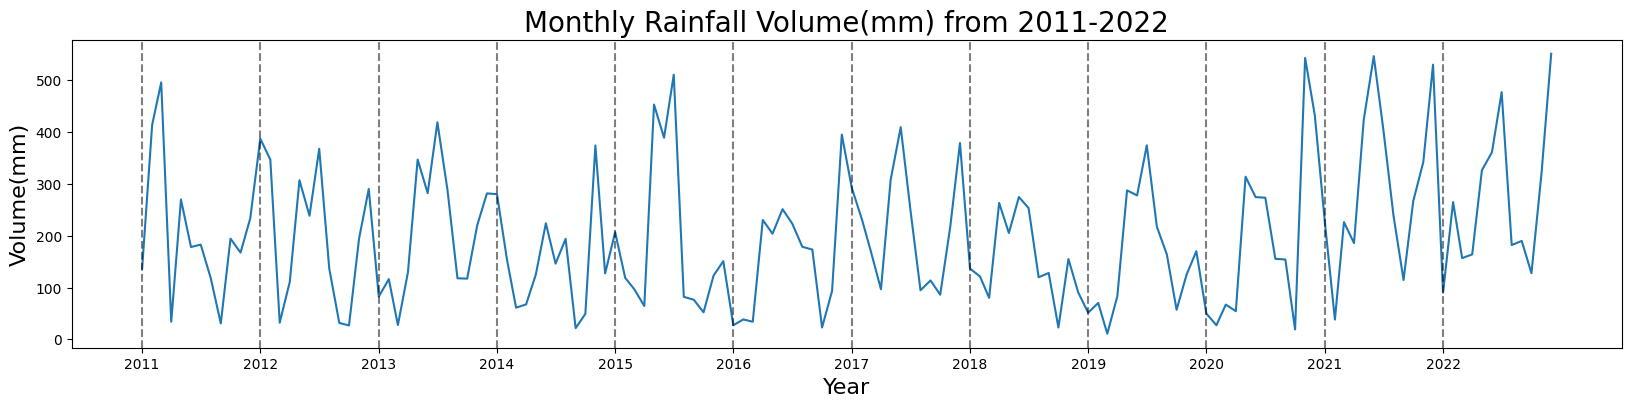

In [370]:
plt.figure(figsize=(20, 4))
start_date = pd.to_datetime("2011-01-01")
end_date = pd.to_datetime("2022-12-01")
df_2011_2022 = df[start_date:end_date]
df_2011_2022.tail()
# ax1.plot()
# fig.tight_layout()
# plt.show()
plt.title("Monthly Rainfall Volume(mm) from 2011-2022", fontsize=20)
plt.ylabel("Volume(mm)", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.plot(df_2011_2022["mean_monthly_rainfall"])
tick_loc = [pd.to_datetime(str(i), format="%Y") for i in range(2011, 2022+1)]
tick_labels = ["{}".format(i.year) for i in tick_loc]
plt.xticks(ticks=tick_loc, labels=tick_labels)
for year in range(2011, 2022+1):
    plt.axvline(pd.to_datetime(str(year)),
                color="k", linestyle='--', alpha=0.5)


ACF


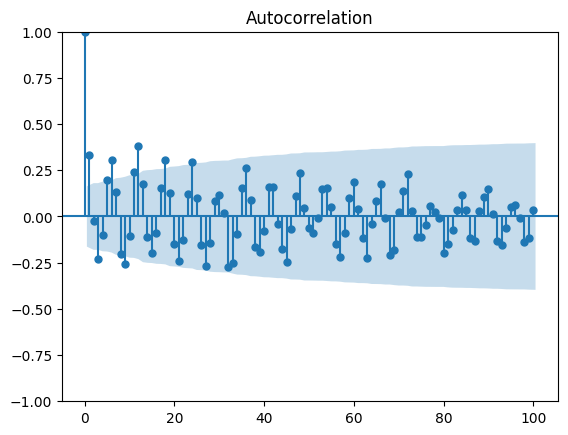

In [371]:
acf_plot = plot_acf(df_2011_2022["mean_monthly_rainfall"], lags=100)


c:\Users\simeo\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


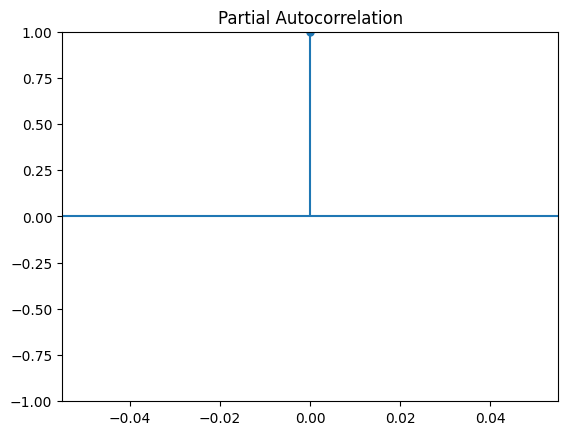

In [372]:
pacf_plot = plot_pacf(df["mean_monthly_rainfall"])


Based on PACF AR should have lags of 1,2,3,4


Get training and testing sets


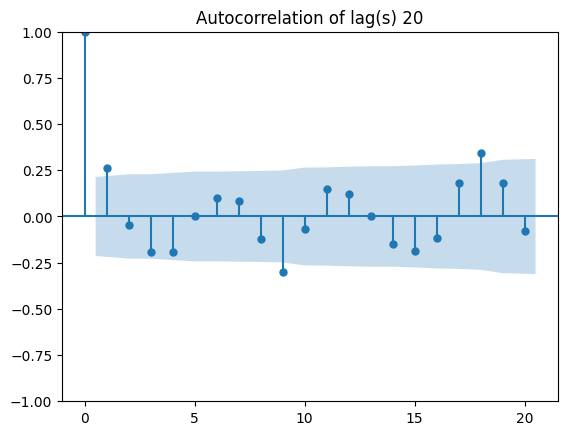

In [373]:
# train_start = datetime(2000,1,1)
train_start = datetime(2010, 1, 1)
train_end = datetime(2016, 12, 1)
test_start = datetime(2017, 1, 1)
test_end = datetime(2017, 12, 1)
# test_end = datetime(2020,12,1)
train_data = df[train_start:train_end]
lags = 20
acf_plot = plot_acf(train_data, lags=lags,
                    title="Autocorrelation of lag(s) {}".format(lags))
# plt.savefig("lag_{}_acf.png".format(lags))
test_data = df[test_start:test_end]
# test_data.head()


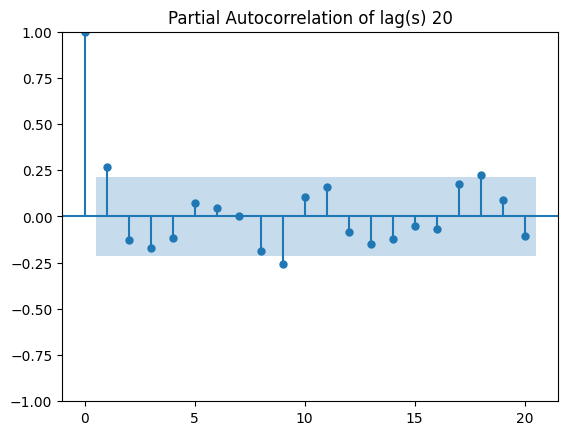

In [374]:
pacf_plot = plot_pacf(train_data, lags=lags,
                      title="Partial Autocorrelation of lag(s) {}".format(lags))
# plt.savefig("lag_{}_pacf.png".format(lags))


Fit the AR model


In [375]:
# create the model
# model = AutoReg(train_data, lags=[1,3,8,9])
model = AutoReg(train_data, lags=lags)
model_fit = model.fit()
print(model_fit.summary().as_csv())


                       AutoReg Model Results                       
Dep. Variable:,mean_monthly_rainfall,  No. Observations:  ,84      
Model:        ,AutoReg(20)          ,  Log Likelihood     ,-377.935
Method:       ,Conditional MLE      ,  S.D. of innovations,88.792  
Date:         ,Sat, 29 Apr 2023     ,  AIC                ,799.870 
Time:         ,02:37:26             ,  BIC                ,847.365 
Sample:       ,09-01-2011           ,  HQIC               ,818.581 
              ,- 12-01-2016         ,                     ,        
                         ,   coef   , std err ,    z    ,P>|z| ,  [0.025 ,  0.975] 
const                    ,  222.2341,  108.407,    2.050, 0.040,    9.760,  434.708
mean_monthly_rainfall.L1 ,    0.1413,    0.127,    1.114, 0.265,   -0.107,    0.390
mean_monthly_rainfall.L2 ,    0.0549,    0.130,    0.421, 0.674,   -0.201,    0.311
mean_monthly_rainfall.L3 ,   -0.2177,    0.126,   -1.729, 0.084,   -0.464,    0.029
mean_monthly_rainfall.L4 ,   -0.1720

In [376]:
# m = ARIMA(train_data, order=([1,2,3,4,5,6,7],5,2))
# m = ARIMA(train_data, order=([1,3,8,9],0,0))
# m_fit = m.fit()
# print(m_fit.summary())


In [377]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date, pred_end_date)


2017-01-01 00:00:00 2017-12-01 00:00:00


In [378]:
predictions = pd.DataFrame(model_fit.predict(
    start=pred_start_date, end=pred_end_date), columns=["predictions"])
residuals = test_data["mean_monthly_rainfall"] - predictions["predictions"]
residuals.head()


date
2017-01-01    -58.212720
2017-02-01    -28.826886
2017-03-01     77.253821
2017-04-01     60.355081
2017-05-01    169.643509
Freq: MS, dtype: float64

Text(0.5, 1.0, 'Prediction Residual Plot - lag(s) 20')

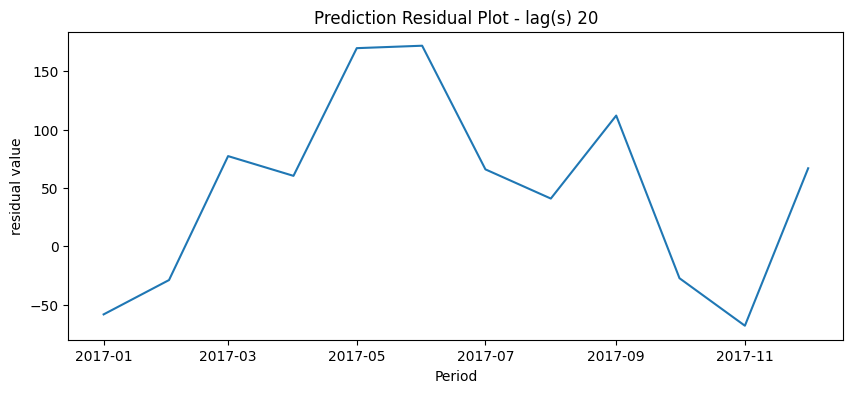

In [379]:
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.xlabel("Period")
plt.ylabel("residual value")
plt.title("Prediction Residual Plot - lag(s) {}".format(lags))
# plt.savefig("lag_{}_prediction_residual_plot.png".format(lags))


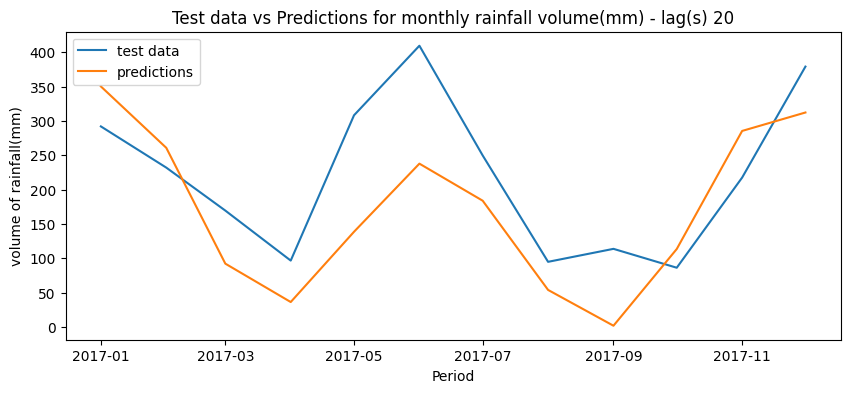

In [380]:
plt.figure(figsize=(10, 4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(("test data", "predictions"))
plt.xlabel("Period")
plt.ylabel("volume of rainfall(mm)")
plt.title(
    "Test data vs Predictions for monthly rainfall volume(mm) - lag(s) {}".format(lags))
plt.savefig("lag_{}_test_vs_predictions.png".format(lags))


In [381]:
# fig = plt.figure(figsize=(16, 9))
# model_fit.plot_diagnostics(fig=fig, lags=10)


Adjusted AR Model


In [382]:
# lags_to_keep = [3, 4, 7, 8, 16, 18, 19]
lags_to_keep_acf_pacf = [1, 9, 18]
lags_to_keep_10 = [3, 8, 18]
lags_to_keep_combined = [1, 3, 8, 9, 18]
model_ar_adjusted_10 = AutoReg(train_data, lags=lags_to_keep_10)
model_ar_adjusted_acf_pacf = AutoReg(train_data, lags=lags_to_keep_acf_pacf)
model_ar_adjusted_combined = AutoReg(train_data, lags=lags_to_keep_combined)
model_fit_adjusted_10 = model_ar_adjusted_10.fit()
model_fit_adjusted_acf_pacf = model_ar_adjusted_acf_pacf.fit()
model_fit_adjusted_combined = model_ar_adjusted_combined.fit()
# print(model_fit_adjusted.summary().as_csv())


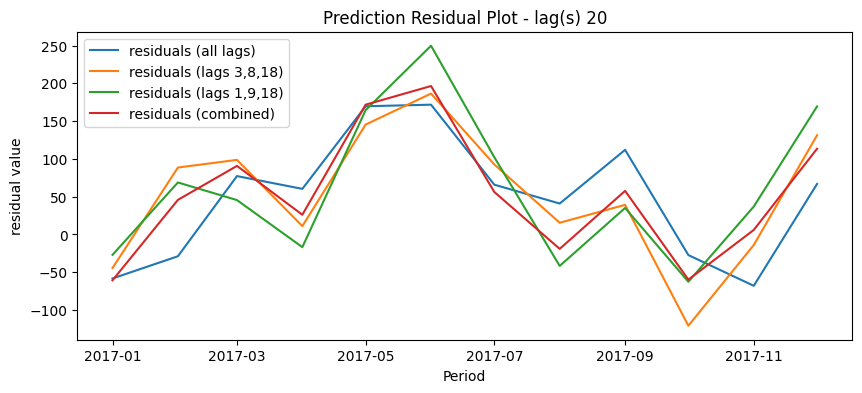

In [383]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
# print(pred_start_date, pred_end_date)
predictions_10 = pd.DataFrame(model_fit_adjusted_10.predict(
    start=pred_start_date, end=pred_end_date), columns=["predictions"])
residuals_10 = test_data["mean_monthly_rainfall"] - \
    predictions_10["predictions"]

predictions_acf_pacf = pd.DataFrame(model_fit_adjusted_acf_pacf.predict(
    start=pred_start_date, end=pred_end_date), columns=["predictions"])
residuals_acf_pacf = test_data["mean_monthly_rainfall"] - \
    predictions_acf_pacf["predictions"]

predictions_combined = pd.DataFrame(model_fit_adjusted_combined.predict(
    start=pred_start_date, end=pred_end_date), columns=["predictions"])
residuals_combined = test_data["mean_monthly_rainfall"] - \
    predictions_combined["predictions"]
# residuals.head()
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.plot(residuals_10)
plt.plot(residuals_acf_pacf)
plt.plot(residuals_combined)
plt.xlabel("Period")
plt.ylabel("residual value")
plt.title("Prediction Residual Plot - lag(s) {}".format(lags))
plt.legend(("residuals (all lags)", "residuals (lags 3,8,18)",
           "residuals (lags 1,9,18)", "residuals (combined)"))
plt.savefig("lag_{}_prediction_residual_plot_adjusted.png".format(lags))


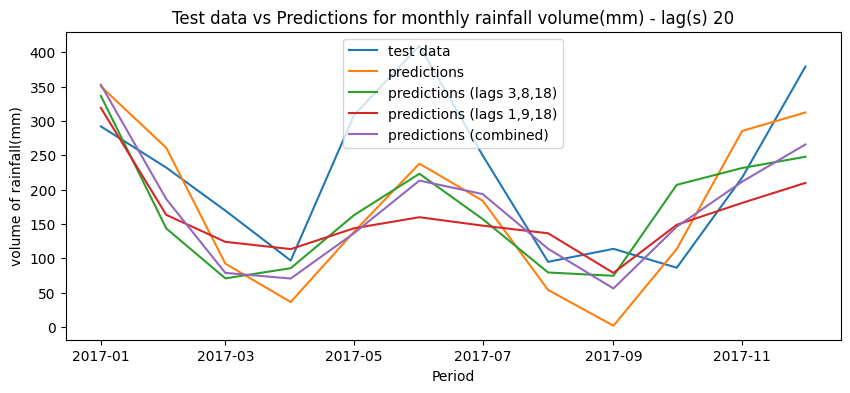

In [384]:
plt.figure(figsize=(10, 4))
plt.plot(test_data)
plt.plot(predictions)
plt.plot(predictions_10)
plt.plot(predictions_acf_pacf)
plt.plot(predictions_combined)
plt.legend(("test data", "predictions", "predictions (lags 3,8,18)",
           "predictions (lags 1,9,18)", "predictions (combined)"))
plt.xlabel("Period")
plt.ylabel("volume of rainfall(mm)")
plt.title(
    "Test data vs Predictions for monthly rainfall volume(mm) - lag(s) {}".format(lags))
plt.savefig("lag_{}_test_vs_predictions_adjusted.png".format(lags))


Comparison of Ajusted Multi-regressive model and Adjusted AR model


In [418]:
x_columns_culled = [
    "mean_monthly_humidity",
    # "mean_monthly_shade_temperature",
    "mean_monthly_sunshine",
    "mean_monthly_min_shade_temperature",
    "mean_monthly_max_shade_temperature",
    # "mean_monthly_morning_humidity",
    # "mean_monthly_afternoon_humidity",
    # "January",
    # "February",
    # "March",
    # "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    # "October",
    "November",
    "December",
]
y_column = "mean_monthly_rainfall"
X = df_multi_2017[x_columns_culled]
X = sm.add_constant(X)
y = df_multi_2017[y_column]
model_multi = sm.OLS(y, X).fit()
predictions_multi = model_multi.predict(X)
model_multi.summary()

# predictions_multi = pd.DataFrame(model_fit_adjusted_10.predict(
#   start=pred_start_date, end=pred_end_date), columns=["predictions"])
# residuals_multi = test_data["mean_monthly_rainfall"] - \
#    predictions_10["predictions"]


c:\Users\simeo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     mean_monthly_rainfall   R-squared:                       0.986
Model:                               OLS   Adj. R-squared:                  0.850
Method:                    Least Squares   F-statistic:                     7.252
Date:                   Sat, 29 Apr 2023   Prob (F-statistic):              0.282
Time:                           03:05:36   Log-Likelihood:                -47.337
No. Observations:                     12   AIC:                             116.7
Df Residuals:                          1   BIC:                             122.0
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                436.5858   2082.427      0.210      0.868    -2.6e+04    2.69e+04
mean_monthly_humidity                 11.0081     17.378      0.633      0.641    -209.804     231.820
mean_monthly_sunshine                -43.8597     45.731     -0.959      0.513    -624.928     537.208
mean_monthly_min_shade_temperature   -13.5183     17.191     -0.786      0.576    -231.955     204.918
mean_monthly_max_shade_temperature   -13.5183     17.191     -0.786      0.576    -231.955     204.918
May                                   20.9816     99.281      0.211      0.867   -1240.507    1282.470
June                                  49.3160    134.660      0.366      0.777   -1661.698    1760.330
July                                   6.7017    102.571      0.065      0.958   -1296.582    1309.985
August                                32.0526     75.170      0.426      0.743    -923.069     987.174
September                             24.6367     70.019      0.352      0.785    -865.034     914.307
November                              19.1088     70.488      0.271      0.831    -876.527     914.745
December                              84.0609     73.272      1.147      0.456    -846.948    1015.070
==============================================================================
Omnibus:                        5.003   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                1.746
Skew:                           0.651   Prob(JB):                        0.418
Kurtosis:                       4.340   Cond. No.                     1.15e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.63e-34. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [419]:
predictions_multi = pd.DataFrame(predictions_multi, columns=["predictions"])


In [420]:
predictions_combined


,predictions
2017-01-01,352.654429
2017-02-01,186.238342
2017-03-01,78.674199
2017-04-01,70.500517
2017-05-01,136.468450
2017-06-01,213.098824
2017-07-01,193.466821
2017-08-01,113.847573
2017-09-01,56.036393
2017-10-01,145.940238


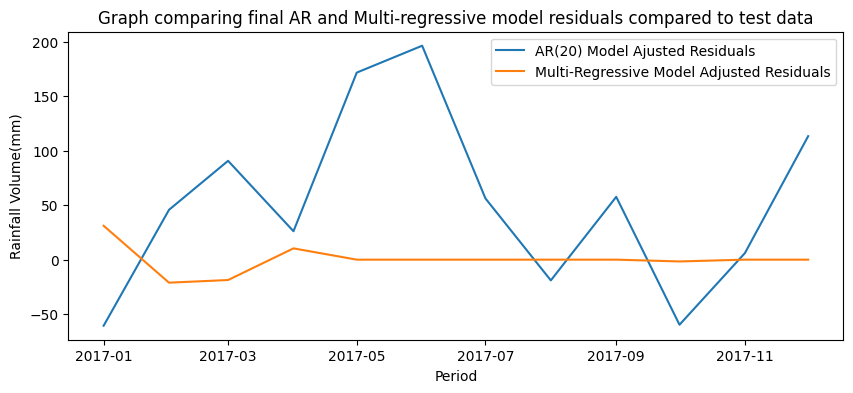

In [423]:

residuals_multi = test_data["mean_monthly_rainfall"] - \
    predictions_multi["predictions"]
plt.figure(figsize=(10, 4))
plt.plot(residuals_combined)
plt.plot(residuals_multi)
plt.xlabel("Period")
plt.ylabel("Rainfall Volume(mm)")
plt.legend(("AR(20) Model Ajusted Residuals",
           "Multi-Regressive Model Adjusted Residuals"))
plt.title("Graph comparing final AR and Multi-regressive model residuals compared to test data")
plt.savefig("final_models_compare_residuals.png".format(lags))


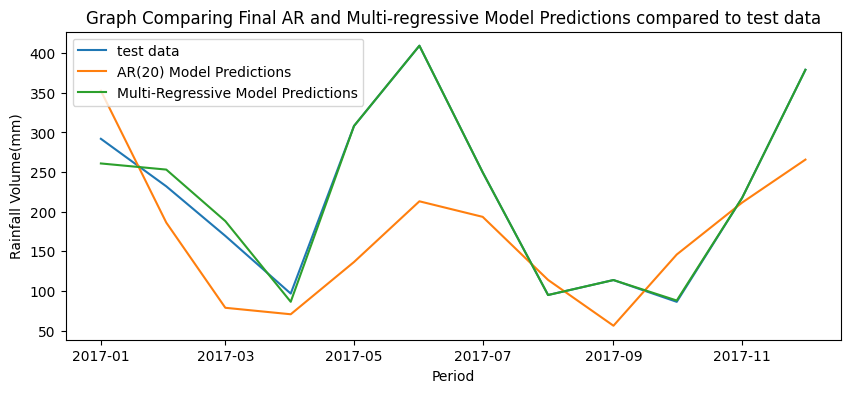

In [424]:
plt.figure(figsize=(10, 4))
plt.plot(test_data)
plt.plot(predictions_combined)
plt.plot(predictions_multi)
plt.xlabel("Period")
plt.ylabel("Rainfall Volume(mm)")
plt.legend(("test data", "AR(20) Model Predictions",
           "Multi-Regressive Model Predictions"))
plt.title(
    "Graph Comparing Final AR and Multi-regressive Model Predictions compared to test data")
plt.savefig("final_models_compare.png".format(lags))
